# Loader + KDE

In [1]:
import sys
sys.path.append('../codes')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
import pylab as plt

from VMSfunctions.Common import save_obj, load_obj, MZ, RT, INTENSITY, N_PEAKS
from VMSfunctions.DataGenerator import DataSource, DensityEstimator, PeakDensityEstimator, PeakSampler

### 1. Load justin beer data

Filtering parameters taken from https://www.dropbox.com/home/Meta_clustering/ms2lda/large_study/r/config?preview=config_beer_pos_3.yml for the beer data.
- rt_start: 3*60
- rt_end: 21*60
- min_MS1_intensity : 1E5 or 2E5 should do a decent job on Polyomics Q-Exactive data
- min_MS2_intensity: 5000

In [5]:
ds = DataSource(min_ms1_intensity=2E5, min_ms2_intensity=5000, min_rt=3*60, max_rt=21*60)

In [6]:
ms1_df = '..\\models\\beer_ms1_peaks.csv.gz'
mzml_path = 'C:\\Users\\joewa\\Work\\docs\\clms\\\FourBeers_mzML_files\\POS\\'
ds.load_data(ms1_df, mzml_path)

C:\Users\joewa\Work\docs\clms\\FourBeers_mzML_files\POS\Beer_1_T10_POS.mzML (ms1=133179, ms2=73454)
C:\Users\joewa\Work\docs\clms\\FourBeers_mzML_files\POS\Beer_2_T10_POS.mzML (ms1=132353, ms2=73049)
C:\Users\joewa\Work\docs\clms\\FourBeers_mzML_files\POS\Beer_3_T10_POS.mzML (ms1=126874, ms2=68107)
C:\Users\joewa\Work\docs\clms\\FourBeers_mzML_files\POS\Beer_QC_T10_POS.mzML (ms1=129562, ms2=65496)


### 2. Train ms1 densities

In [7]:
densities = DensityEstimator()

In [8]:
ms_level = 1

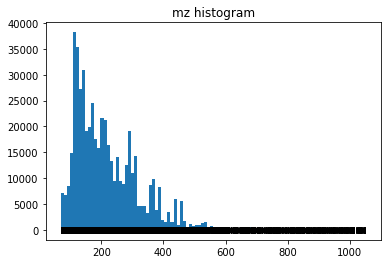

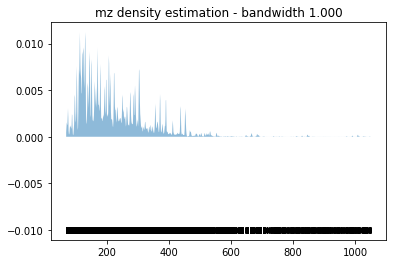

In [9]:
data_type = MZ
ds.plot_histogram(data_type, ms_level)
densities.kde(ds, data_type, ms_level, log=False, bandwidth=1.0, plot=True)

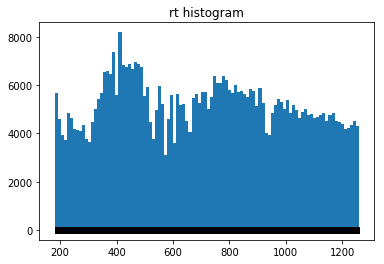

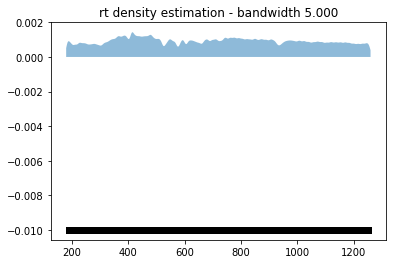

In [10]:
data_type = RT
ds.plot_histogram(data_type, ms_level)
densities.kde(ds, data_type, ms_level, log=False, bandwidth=5.0, plot=True)

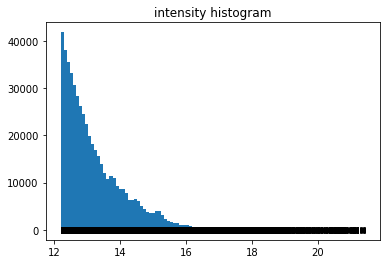

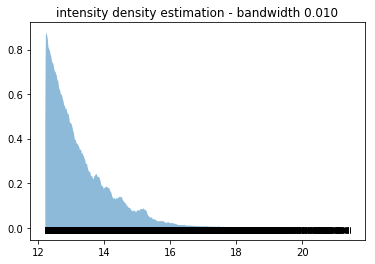

In [11]:
data_type = INTENSITY
ds.plot_histogram(data_type, ms_level, log=True)
densities.kde(ds, data_type, ms_level, log=True, bandwidth=0.01, plot=True)

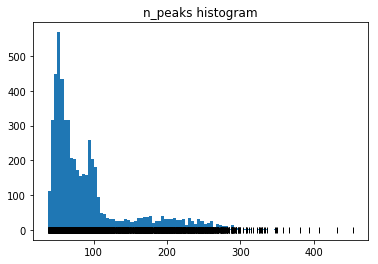

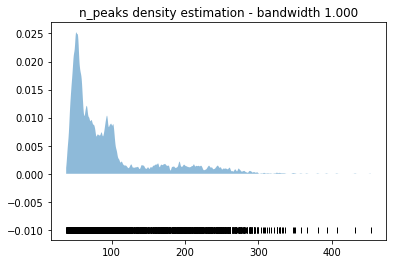

In [12]:
data_type = N_PEAKS
ds.plot_histogram(data_type, ms_level)
densities.kde(ds, data_type, ms_level, log=False, bandwidth=1, plot=True)

In [13]:
densities.sample(ms_level, 10)

array([[ 145.13549344,   12.90927998,  702.58377815],
       [ 139.15051001,   12.59664867, 1083.59953516],
       [ 291.81774024,   12.60529421,  888.70631907],
       [ 224.99357105,   12.79498531,  519.7940526 ],
       [ 130.66006802,   14.84262643,  234.69009994],
       [ 308.27010781,   12.8842651 , 1005.21388355],
       [ 214.60718817,   12.38141062, 1042.0111949 ],
       [ 365.42141418,   12.79347807,  330.65230143],
       [ 293.47113245,   12.23288632,  511.11842689],
       [ 292.51938813,   12.60950825, 1148.75968508]])

### 3. Train ms2 densities

In [14]:
ms_level = 2

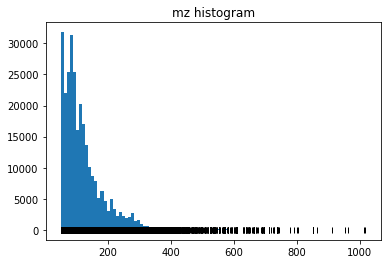

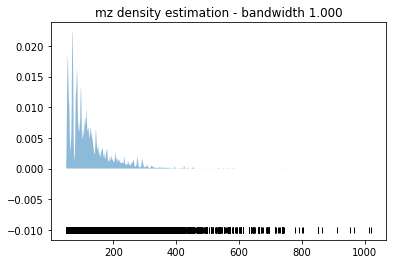

In [15]:
data_type = MZ
ds.plot_histogram(data_type, ms_level)
densities.kde(ds, data_type, ms_level, log=False, bandwidth=1.0, plot=True)

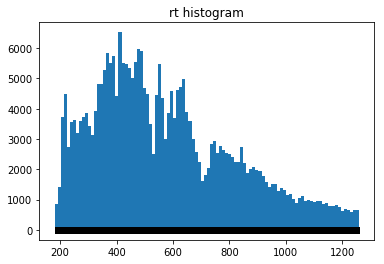

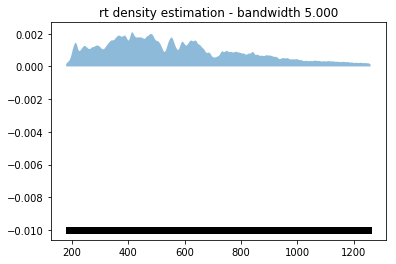

In [16]:
data_type = RT
ds.plot_histogram(data_type, ms_level)
densities.kde(ds, data_type, ms_level, log=False, bandwidth=5, plot=True)

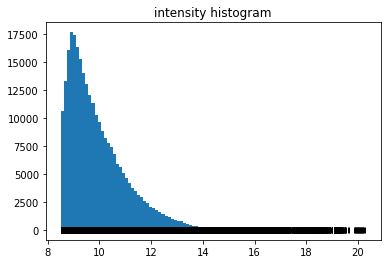

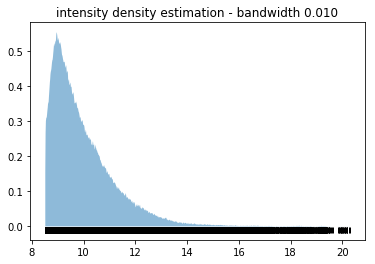

In [17]:
data_type = INTENSITY
ds.plot_histogram(data_type, ms_level, log=True)
densities.kde(ds, data_type, ms_level, log=True, bandwidth=0.01, plot=True)

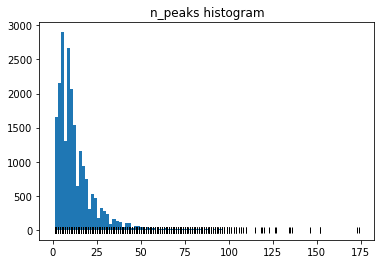

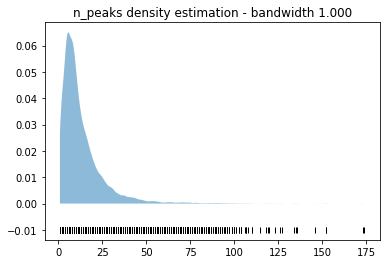

In [18]:
data_type = N_PEAKS
ds.plot_histogram(data_type, ms_level)
densities.kde(ds, data_type, ms_level, log=False, bandwidth=1, plot=True)

In [19]:
densities.sample(ms_level, 10)

array([[  59.90405654,    9.102144  ,  312.89960452],
       [  54.13563294,   10.20909746,  758.56354204],
       [  70.89393456,   10.70422817,  623.4588646 ],
       [  98.98571284,   10.19177077,  397.08081605],
       [ 131.34956257,    9.3776543 ,  632.00685727],
       [ 262.77892856,   11.59725366,  493.33907174],
       [ 124.17881371,    8.75063995,  399.23048858],
       [ 120.0687731 ,    9.16581037,  310.39814889],
       [  56.68987301,   10.38591617,  293.30901866],
       [ 151.93013221,   10.0841676 , 1012.88506833]])

### 4. Alternative KDE where we fit the m/z and intensity together

In [20]:
densities = PeakDensityEstimator()
densities.kde(ds, 1, bandwidth_mz_int=1.0, bandwidth_rt=5.0, bandwidth_n_peaks=1.0)
densities.kde(ds, 2, bandwidth_mz_int=1.0, bandwidth_rt=5.0, bandwidth_n_peaks=1.0)

In [21]:
densities.sample(1, 10)

array([[ 122.46611144,   14.3683015 ,  278.11642994],
       [ 124.55460711,   13.00301049, 1038.95582878],
       [ 313.29820433,   12.70026112,  528.12440361],
       [ 111.84610624,   13.56913605,  301.6110533 ],
       [ 224.90692835,   11.46018036,  734.29198328],
       [ 115.27889695,   12.13241184,  780.00964141],
       [ 123.67167265,   15.06822955,  269.17451086],
       [  98.82059155,   14.89251402,  874.93645453],
       [ 349.66281008,   13.51763727, 1232.6345009 ],
       [ 264.83257533,   12.39546519,  354.54918023]])

In [22]:
densities.n_peaks(1, 10)

array([[ 73.11926094],
       [ 98.24607138],
       [269.81727736],
       [ 93.75283581],
       [ 48.46790672],
       [ 77.2100967 ],
       [ 53.71612757],
       [ 56.69935016],
       [ 76.91922692],
       [ 68.58828592]])

In [23]:
densities.sample(2, 10)

array([[ 196.6055111 ,   11.78592855,  686.52973625],
       [  72.41379759,    9.65297861, 1076.61523085],
       [ 127.33898456,    9.77359075,  242.29181932],
       [  52.18774169,    9.26026757,  347.23223677],
       [ 274.12262634,    9.42311835,  475.58149494],
       [ 123.58671801,    7.77087218,  326.26996268],
       [ 199.5289946 ,   11.05527286,  311.16244285],
       [ 107.4192229 ,    6.74845921,  953.14745285],
       [  83.91452703,    7.08303173,  300.79274956],
       [  56.78458774,   10.09072853,  721.89868739]])

In [24]:
densities.n_peaks(2, 10)

array([[28.22779282],
       [10.15183246],
       [ 5.25740893],
       [38.86359415],
       [ 7.71094254],
       [ 7.61737716],
       [11.23169701],
       [ 9.71190093],
       [ 3.07243785],
       [16.80177216]])

### 5. Generate some synthetic peaks

In [25]:
ps = PeakSampler(densities)
save_obj(ps, '../models/peak_sampler_4_beers.p')

In [26]:
ps = load_obj('../models/peak_sampler_4_beers.p')

In [27]:
ps.sample(ms_level=1)

[PeakSample mz=151.5880 rt=273.71 intensity=15876.65 ms_level=1,
 PeakSample mz=267.7210 rt=853.23 intensity=234094.32 ms_level=1,
 PeakSample mz=115.6811 rt=360.98 intensity=663433.05 ms_level=1,
 PeakSample mz=515.5449 rt=717.46 intensity=808148.85 ms_level=1,
 PeakSample mz=136.2419 rt=342.92 intensity=587788.61 ms_level=1,
 PeakSample mz=453.5938 rt=615.66 intensity=1170941.16 ms_level=1,
 PeakSample mz=389.5332 rt=762.02 intensity=116919.92 ms_level=1,
 PeakSample mz=199.2414 rt=1112.85 intensity=823269.25 ms_level=1,
 PeakSample mz=224.4625 rt=693.13 intensity=515307.75 ms_level=1,
 PeakSample mz=112.5648 rt=1179.08 intensity=6821192.97 ms_level=1,
 PeakSample mz=403.1425 rt=967.26 intensity=60338.96 ms_level=1,
 PeakSample mz=285.1774 rt=561.45 intensity=35964.94 ms_level=1,
 PeakSample mz=127.0546 rt=1218.20 intensity=505575.27 ms_level=1,
 PeakSample mz=89.2587 rt=1065.77 intensity=70897.48 ms_level=1,
 PeakSample mz=278.9804 rt=533.33 intensity=7163880.80 ms_level=1,
 PeakSam

In [28]:
ps.sample(ms_level=1, n_peaks=10)

[PeakSample mz=307.4655 rt=1184.24 intensity=484189.68 ms_level=1,
 PeakSample mz=469.4174 rt=773.30 intensity=125583.88 ms_level=1,
 PeakSample mz=172.4068 rt=697.49 intensity=1993525.73 ms_level=1,
 PeakSample mz=187.0807 rt=348.64 intensity=1049013.50 ms_level=1,
 PeakSample mz=308.6809 rt=870.47 intensity=167564.79 ms_level=1,
 PeakSample mz=194.4396 rt=1039.53 intensity=2446362.35 ms_level=1,
 PeakSample mz=265.4357 rt=1212.94 intensity=75853.47 ms_level=1,
 PeakSample mz=260.3464 rt=797.31 intensity=241167.28 ms_level=1,
 PeakSample mz=161.6837 rt=739.55 intensity=2983678.03 ms_level=1,
 PeakSample mz=234.3630 rt=880.38 intensity=232427.74 ms_level=1]

In [29]:
ps.sample(ms_level=2)

[]

In [30]:
ps.sample(ms_level=2, n_peaks=10)

[PeakSample mz=136.2830 rt=893.83 intensity=6295.44 ms_level=2,
 PeakSample mz=70.5186 rt=958.13 intensity=3822.03 ms_level=2,
 PeakSample mz=197.7833 rt=647.54 intensity=45829.47 ms_level=2,
 PeakSample mz=111.3108 rt=837.47 intensity=29318.28 ms_level=2,
 PeakSample mz=84.8791 rt=449.93 intensity=17642.50 ms_level=2,
 PeakSample mz=85.7899 rt=470.20 intensity=6170.42 ms_level=2,
 PeakSample mz=52.4748 rt=345.55 intensity=2071.79 ms_level=2,
 PeakSample mz=69.7197 rt=576.11 intensity=28235.21 ms_level=2,
 PeakSample mz=55.7592 rt=511.67 intensity=23887.95 ms_level=2,
 PeakSample mz=105.6301 rt=356.23 intensity=18364.18 ms_level=2]

### 6. Train on Justin's Urine Data

In [ ]:
ds = DataSource(min_ms1_intensity=2E5, min_ms2_intensity=5000, min_rt=3*60, max_rt=21*60, min_sn=100)
ds.load_data('C:\\Users\\joewa\\Work\\docs\\clms\\Urines100Study_mzml_files_peaklist\\mzml_files')

In [ ]:
densities = PeakDensityEstimator()
densities.kde(ds, 1, bandwidth_mz_int=1.0, bandwidth_rt=5.0, bandwidth_n_peaks=1.0)
densities.kde(ds, 2, bandwidth_mz_int=1.0, bandwidth_rt=5.0, bandwidth_n_peaks=1.0)

In [ ]:
ps = PeakSampler(densities)
save_obj(ps, '../models/peak_sampler_100_urines.p')

In [ ]:
ps = load_obj('../models/peak_sampler_100_urines.p')

In [ ]:
ps.sample(ms_level=1)

In [ ]:
ps.sample(ms_level=2)